In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [ ]:
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()

df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
# ---------------------------
# Task 1: Data Exploration
# ---------------------------
print("==== Data head ====")
print(df.head())
print("\n==== Data info ====")
print(df.info())

# Missing values
missing = df.isnull().sum()
print("\n==== Missing values per column ====")
print(missing)


==== Data head ====
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

==== Data info ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms  

In [ ]:
# outliers detection
def outlier_detection(df):
    counts = {}
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR
        counts[col] = int(((df[col]<low) | (df[col] > high)).sum())
    return pd.Series(counts).sort_values(ascending=False)

print("\n==== Outlier counts (IQR) ====")
print(outlier_detection(df))


==== Outlier counts (IQR) ====
AveBedrms      1424
Population     1196
MedHouseVal    1071
AveOccup        711
MedInc          681
AveRooms        511
HouseAge          0
Latitude          0
Longitude         0
dtype: int64


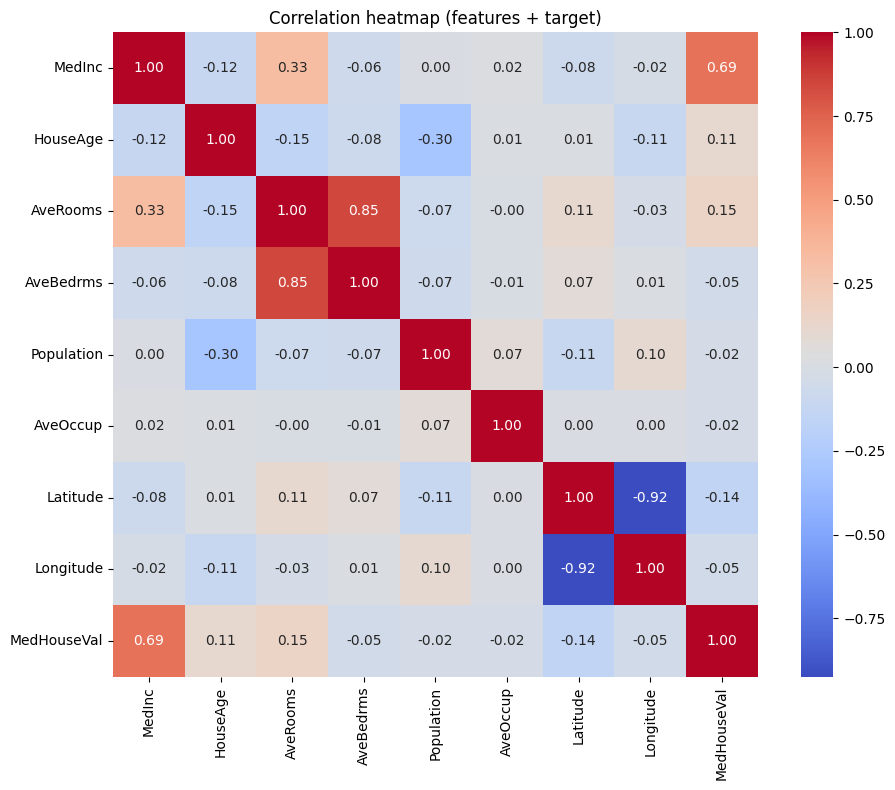

In [24]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation heatmap (features + target)")
plt.tight_layout()
plt.show()

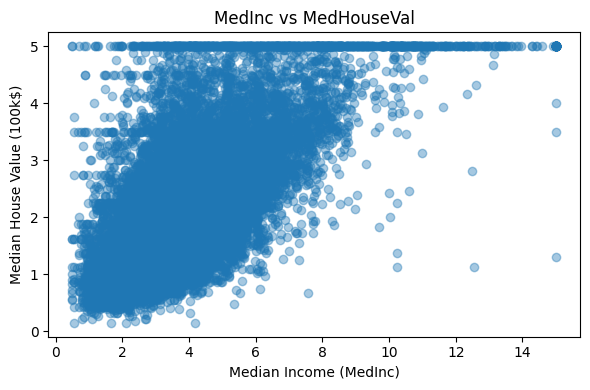

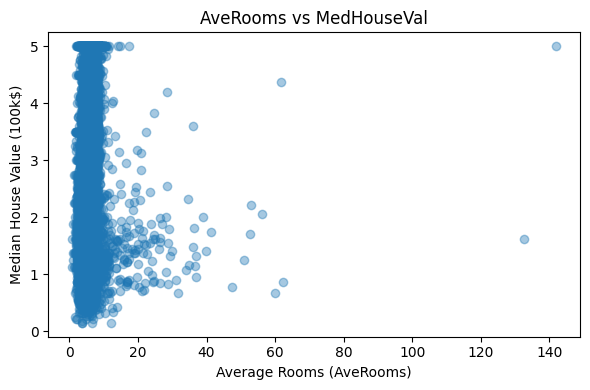

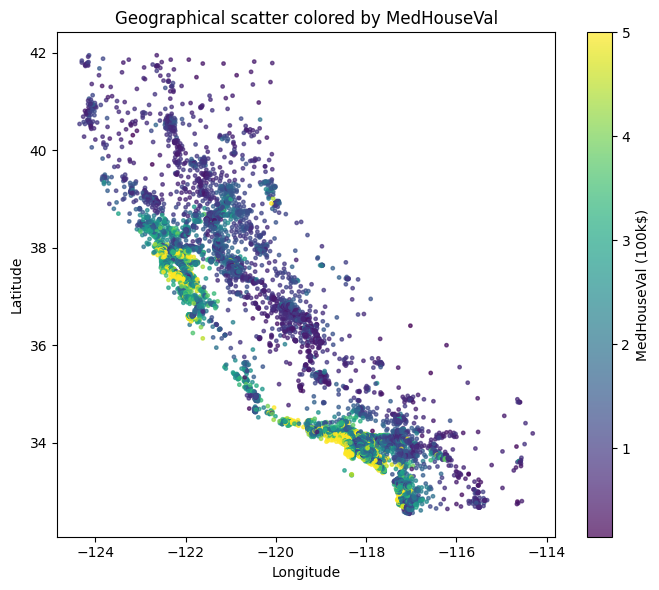

In [25]:
# Scatter plots for key relationships
plt.figure(figsize=(6,4))
plt.scatter(df["MedInc"], df["MedHouseVal"], alpha=0.4)
plt.xlabel("Median Income (MedInc)")
plt.ylabel("Median House Value (100k$)")
plt.title("MedInc vs MedHouseVal")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(df["AveRooms"], df["MedHouseVal"], alpha=0.4)
plt.xlabel("Average Rooms (AveRooms)")
plt.ylabel("Median House Value (100k$)")
plt.title("AveRooms vs MedHouseVal")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
sc = plt.scatter(df["Longitude"], df["Latitude"], c=df["MedHouseVal"], cmap="viridis", s=6, alpha=0.7)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographical scatter colored by MedHouseVal")
plt.colorbar(sc, label="MedHouseVal (100k$)")
plt.tight_layout()
plt.show()

In [26]:
# ---------------------------
# Task 2: Data Preprocessing
# ---------------------------

# Handle missing values (if any) - for this dataset there usually are none.
if missing.sum() > 0:
    print("\nMissing values detected — using simple imputation (median).")
    df = df.fillna(df.median())

# Split features/target
X = df.drop(columns=["MedHouseVal"])
y = df["MedHouseVal"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


In [27]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Keep track of column names
feature_cols = list(X.columns)

In [28]:
# Create polynomial features for one variable: MedInc (median income)
if "MedInc" not in feature_cols:
    raise KeyError("Expected 'MedInc' feature in dataset")

medinc_idx = feature_cols.index("MedInc")

poly = PolynomialFeatures(degree=POLY_DEGREE, include_bias=False)
# Extract only MedInc column for poly
medinc_train = X_train_scaled[:, medinc_idx].reshape(-1,1)
medinc_test = X_test_scaled[:, medinc_idx].reshape(-1,1)
medinc_poly_train = poly.fit_transform(medinc_train)   # shape: (n_samples, degree)
medinc_poly_test = poly.transform(medinc_test)

In [29]:
# Replace MedInc with its polynomial columns in feature matrix
def replace_medinc_with_poly(X_scaled, medinc_poly, medinc_idx, original_feature_names):
    X_without = np.delete(X_scaled, medinc_idx, axis=1)
    X_new = np.hstack([X_without, medinc_poly])
    # build new feature names
    new_names = [name for i,name in enumerate(original_feature_names) if i != medinc_idx]
    # append polynomial names (e.g., MedInc, MedInc^2)
    poly_names = []
    for deg in range(1, medinc_poly.shape[1]+1):
        if deg == 1:
            poly_names.append("MedInc")
        else:
            poly_names.append(f"MedInc^{deg}")
    new_feature_names = new_names + poly_names
    return X_new, new_feature_names

X_train_final, feature_names_final = replace_medinc_with_poly(X_train_scaled, medinc_poly_train, medinc_idx, feature_cols)
X_test_final, _ = replace_medinc_with_poly(X_test_scaled, medinc_poly_test, medinc_idx, feature_cols)

print("\nFinal feature count:", len(feature_names_final))
print("Final feature names (last ones are polynomial MedInc):")


Final feature count: 9
Final feature names (last ones are polynomial MedInc):


In [30]:
# ---------------------------
# Task 3: Model Implementation
# ---------------------------
def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_final, y_train)
y_pred_lr = lr.predict(X_test_final)
metrics_lr = eval_metrics(y_test, y_pred_lr)

# Ridge Regression
ridge = Ridge(alpha=RIDGE_ALPHA, random_state=RANDOM_STATE)
ridge.fit(X_train_final, y_train)
y_pred_ridge = ridge.predict(X_test_final)
metrics_ridge = eval_metrics(y_test, y_pred_ridge)

In [31]:
# ---------------------------
# Task 4: Analysis & Insights
# ---------------------------

# Coefficients (Linear Regression)
coef_series = pd.Series(lr.coef_, index=feature_names_final)
coef_sorted = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)

print("\n==== Evaluation metrics (Linear Regression) ====")
for k,v in metrics_lr.items():
    print(f"{k}: {v:.4f}")
print("\n==== Evaluation metrics (Ridge Regression, alpha={}) ====".format(RIDGE_ALPHA))
for k,v in metrics_ridge.items():
    print(f"{k}: {v:.4f}")

# Compare models quickly
print("\nR^2 improvement (Ridge - Linear):", metrics_ridge["R2"] - metrics_lr["R2"])

# Top features by absolute coefficient (Linear model)
print("\n==== Top features by absolute coefficient (Linear Regression) ====")
print(coef_sorted.head(10))

# Show sample of actual vs predicted
sample_results = pd.DataFrame({
    "Actual": y_test.values,
    "Pred_LR": y_pred_lr,
    "Pred_Ridge": y_pred_ridge
})
print("\n==== Sample predictions (first 15 test samples) ====")
print(sample_results.head(15).round(3))


==== Evaluation metrics (Linear Regression) ====
MSE: 0.5560
RMSE: 0.7456
MAE: 0.5342
R2: 0.5757

==== Evaluation metrics (Ridge Regression, alpha=1.0) ====
MSE: 0.5559
RMSE: 0.7456
MAE: 0.5342
R2: 0.5758

R^2 improvement (Ridge - Linear): 3.944707000103076e-05

==== Top features by absolute coefficient (Linear Regression) ====
MedInc        0.955617
Latitude     -0.845946
Longitude    -0.822967
AveBedrms     0.390471
AveRooms     -0.353046
HouseAge      0.134478
MedInc^2     -0.043858
AveOccup     -0.040373
Population   -0.004929
dtype: float64

==== Sample predictions (first 15 test samples) ====
    Actual  Pred_LR  Pred_Ridge
0    0.477    0.629       0.630
1    0.458    1.727       1.727
2    5.000    2.784       2.783
3    2.186    2.889       2.889
4    2.780    2.605       2.604
5    1.587    2.072       2.073
6    1.982    2.720       2.720
7    1.575    2.212       2.212
8    3.400    2.814       2.813
9    4.466    3.936       3.936
10   1.232    0.950       0.950
11   2.53

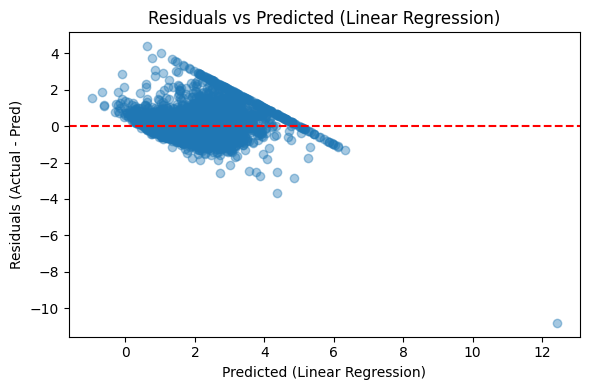


==== Short Analysis & Suggestions ====
- Most important features (by absolute coefficient):
  MedInc: coef=0.9556
  Latitude: coef=-0.8459
  Longitude: coef=-0.8230
  AveBedrms: coef=0.3905
  AveRooms: coef=-0.3530
  HouseAge: coef=0.1345
  MedInc^2: coef=-0.0439


In [32]:
# Residual plot for Linear model
residuals = y_test.values - y_pred_lr
plt.figure(figsize=(6,4))
plt.scatter(y_pred_lr, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted (Linear Regression)")
plt.ylabel("Residuals (Actual - Pred)")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.tight_layout()
plt.show()

# ---------------------------
# Short discussion printed
# ---------------------------
print("\n==== Short Analysis & Suggestions ====")
print("- Most important features (by absolute coefficient):")
for feat, val in coef_sorted.head(7).items():
    print(f"  {feat}: coef={val:.4f}")